# Configuring demography
The {class}`~phasegen.distributions.Coalescent` expects a demography object to be passed to it, which can be configured in various ways. When constructing a demography object, you can directly specify the time points at which the population sizes or migration rates change.

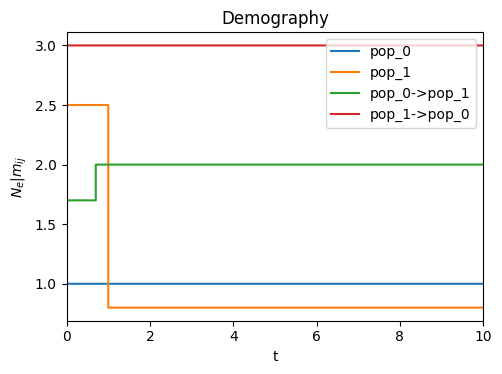

In [1]:
import phasegen as pg

d = pg.Demography(
    pop_sizes={'pop_0': {0: 1}, 'pop_1': {0: 2.5, 1: 0.8}},
    migration_rates={
        ('pop_0', 'pop_1'): {0: 1.7, 0.7: 2},
        ('pop_1', 'pop_0'): {0: 3}
    }
)

d.plot();

Alternatively, you can configure the demography object after construction by adding demographic events. Below, we add {class}`~phasegen.demography.PopSizeChange` and {class}`~phasegen.demography.MigrationRateChange` events to the demography object.

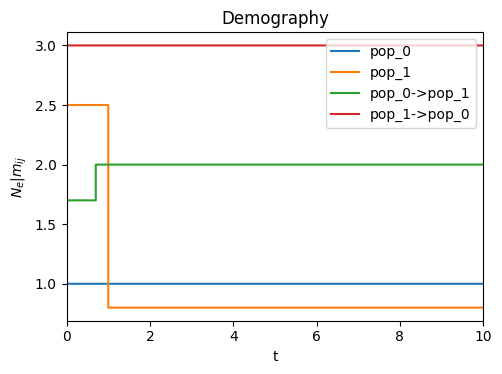

In [2]:
d = pg.Demography()

d.add_event(pg.PopSizeChange(pop='pop_0', time=0, size=1))
d.add_event(pg.PopSizeChange(pop='pop_1', time=0, size=2.5))
d.add_event(pg.PopSizeChange(pop='pop_1', time=1, size=0.8))

d.add_event(pg.MigrationRateChange(source='pop_0', dest='pop_1', time=0, rate=1.7))
d.add_event(pg.MigrationRateChange(source='pop_0', dest='pop_1', time=0.7, rate=2))
d.add_event(pg.MigrationRateChange(source='pop_1', dest='pop_0', time=0, rate=3))

d.plot();

This is similar to the [msprime demography API](https://tskit.dev/msprime/docs/stable/demography.html), and we can easily convert to an msprime demography object. Note that the reverse, converting an msprime demography to a native {class}`~phasegen.demography.Demography` object, is not currently supported due to PhaseGen's inherent restriction to discrete rate changes.

In [3]:
d_msprime = d.to_msprime()

## Discretizing continuous demographies
There are also utilities for discretizing continuous demographies. In the example below, we create a discretized demography by passing a continuous callback function to {class}`~phasegen.demography.DiscretizedRateChange`. You can freely combine this with other demographic events. Note that the total runtime of the coalescent simulation is linear in the number of epochs, i.e., it is roughly a multiple of the number of epochs.

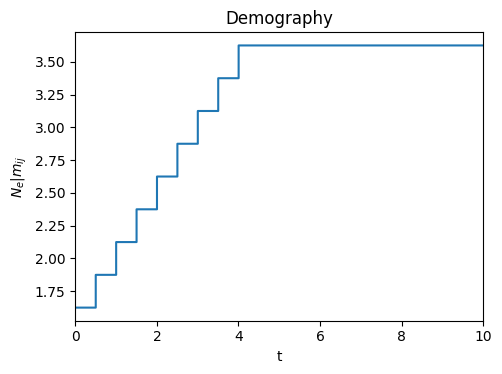

In [4]:
d = pg.Demography(
    events=[
        pg.DiscretizedRateChange(
            trajectory=lambda t: 1.5 + 0.5 * t,
            pop='pop_0',
            start_time=0,
            end_time=5,
            step_size=0.5
        )
    ]
)

d.plot();

For exponential growth or decline, you can also make use of {class}`~phasegen.demography.ExponentialPopSizeChanges`.

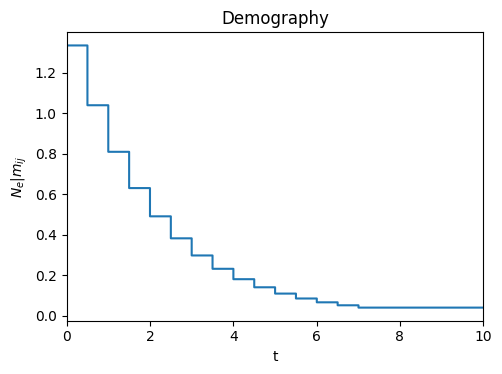

In [5]:
d = pg.Demography(
    events=[
        pg.ExponentialPopSizeChanges(
            initial_size={'pop_0': 1.5},
            growth_rate=0.5,
            start_time=0,
            end_time=8,
            step_size=0.5
        )
    ]
)

d.plot();

## Population splits
Population splits (forwards in time) correspond to population mergers (backwards in time). Since PhaseGen does not support deterministic lineage movements due to its inherent structure, we can model a population split by specifying a large unidirectional migration rate from the derived to the ancestral population. Below, we model a population split where ``pop_0`` splits from ``pop_1`` at time 2. This corresponds to a population merger of the two populations at time 2 backwards in time, and we thus need to initialize both populations at time 0 in the present.

In [6]:
d = pg.Demography(
    pop_sizes={'pop_0': 1, 'pop_1': 3},
    events=[
        pg.PopulationSplit(
            derived='pop_0',
            ancestral='pop_1',
            time=2
        )
    ]
)

Plotting the migration rates, we see that there is a large migration rate from ``pop_0`` to ``pop_1`` at time 2. All migration rates to the derived population (``pop_0``) are furthermore set to 0 at the time of the split.

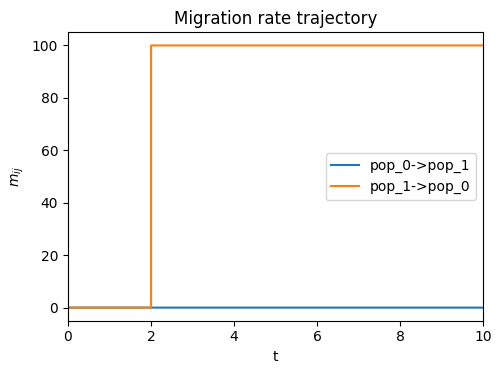

In [7]:
d.plot_migration();

Wrapping in a {class}`~phasegen.distributions.Coalescent` object, by specifying the initial numbers of lineages in each population, we can visualize the tree height distribution. We see that the probability of absorption is 0 after to the split (forwards in time). This is because our scenario represents a *clean* population split, where the derived population is completely isolated from the ancestral population after the split, which makes coalescence between the two populations impossible.

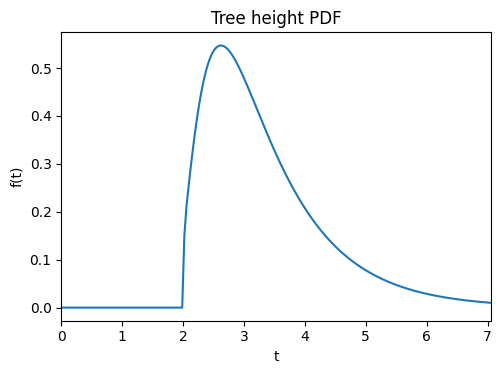

In [8]:
coal = pg.Coalescent(
    n={'pop_0': 4, 'pop_1': 4},
    demography=d
)

coal.tree_height.plot_pdf();

## Population mergers
Population mergers (forwards in time) correspond to population splits (backwards in time). Mergers of populations that were completely isolated prior to the merger are difficult to model in a coalescent framework. This is because, backwards in time, we would end up with isolated populations which would not be able to coalesce. We can thus only model mergers of populations, provided they are in contact again eventually. Below an example 

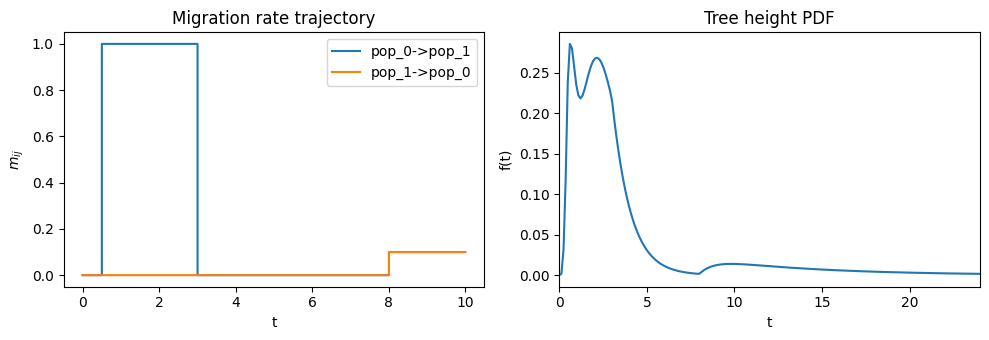

In [9]:
import matplotlib.pyplot as plt

coal = pg.Coalescent(
    n={'pop_0': 8, 'pop_1': 0},
    demography=pg.Demography(
        pop_sizes={'pop_0': 1, 'pop_1': 1},
        events=[
            pg.MigrationRateChanges(
                {
                    ('pop_1', 'pop_0'): {2: 0, 3: 0, 8: 0.1},
                    ('pop_0', 'pop_1'): {0.5: 1, 3: 0, 8: 0.1}
                }
            )
        ]
    )
)

_, axs = plt.subplots(1, 2, figsize=(10, 3.5))
coal.demography.plot_migration(ax=axs[0])
coal.tree_height.plot_pdf(ax=axs[1]);